In [37]:
import pandas as pd
import sqlite3
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import re
import plotly.express as px

import plotly.graph_objects as go
from ipywidgets import widgets

import chart_studio.plotly as py

import chart_studio
chart_studio.tools.set_credentials_file(username='ceverest', api_key='V6TM2axFVMohJrseeMna')

In [57]:
#Show all columns in dataframe by scrolling to the right
pd.options.display.max_columns = None
#Make each column accomodate full text
pd.set_option('display.max_colwidth', 0)
#Print up to 150 rows
pd.options.display.max_rows = 150

#### Query nash_hospitals table from database

In [3]:
db = sqlite3.connect('../data/nppes_lite.sqlite') #reopen the connection

#select 
#exclude grouping: "Nursing Service Providers","Physician Assistants & Advanced Practice Nursing Providers",
query = """
    SELECT
       *
       FROM nash_hospitals
"""

nash_hospitals = pd.read_sql(query,db)

db.close()

In [5]:
df=nash_hospitals
fig = px.bar(df, 
             x='to_facility_group',
             y='total_patients', 
             color='to_facility_name_normalised',
            title='Patient Volume by Facility & Hosptial Group - NOT filtered by referring physician type')
fig.show()

### Join nash_referrals and nash_hospitals as hospital_refs

In [6]:
db = sqlite3.connect('../data/nppes_lite.sqlite') #reopen the connection

#select 
#exclude grouping: "Nursing Service Providers","Physician Assistants & Advanced Practice Nursing Providers",
query = """
SELECT
    from_npi,
    nash_referrals.to_npi,
    from_physician,
    to_facility_name_normalised AS to_facility,
    to_facility_group AS hospital_group,
    from_address,
    nash_referrals.to_address,
    from_tax,
    to_tax,
    from_grouping,
    nash_referrals.to_grouping,
    from_classification,
    nash_referrals.to_classification,
    from_specialization,
    to_specialization,
    from_display_name,
    to_display_name,
    patient_count,
    transaction_count,
    average_day_wait    
FROM nash_referrals
INNER JOIN nash_hospitals
ON nash_hospitals.to_npi = nash_referrals.to_npi
"""

hosp_refs = pd.read_sql(query,db)

db.close()
print(hosp_refs.shape)
print(hosp_refs.columns.tolist())

(6425, 20)
['from_npi', 'to_npi', 'from_physician', 'to_facility', 'hospital_group', 'from_address', 'to_address', 'from_tax', 'to_tax', 'from_grouping', 'to_grouping', 'from_classification', 'to_classification', 'from_specialization', 'to_specialization', 'from_display_name', 'to_display_name', 'patient_count', 'transaction_count', 'average_day_wait']


#### Write hosp_refs to database as table

In [113]:
#db = sqlite3.connect('../data/nppes_lite.sqlite')
#hosp_refs.to_sql('hosp_refs', db, if_exists='append', index=False)
#db.close()

In [7]:
hosp_refs.sample()

from_npi      to_npi    from_physician                    to_facility  \
439  1760473987  1023055126  JEFFREY LAWRENCE  Centennial Medical Center HCA   

    hospital_group    from_address         to_address    from_tax      to_tax  \
439  HCA            345 23RD AVE N  2300 PATTERSON ST  207X00000X  282N00000X   

                           from_grouping to_grouping  from_classification  \
439  Allopathic & Osteopathic Physicians  Hospitals   Orthopaedic Surgery   

               to_classification from_specialization to_specialization  \
439  General Acute Care Hospital  None                None               

                 from_display_name              to_display_name  \
439  Orthopaedic Surgery Physician  General Acute Care Hospital   

     patient_count  transaction_count  average_day_wait  
439  203            310                30.765

### Query provider referrals aggregated by from_grouping and hospital_group

In [ ]:
db = sqlite3.connect('../data/nppes_lite.sqlite') #reopen the connection

#select facility name where facility has to_grouping of 'Hospitals'

query = """
SELECT
    from_classification,
    from_display_name,
    hospital_group,
    COUNT(DISTINCT(from_npi)) AS count_from_npi,
    COUNT(DISTINCT(to_facility)) AS count_facilities,
    SUM(patient_count) AS total_patients,
    SUM(transaction_count) AS total_transactions,
    ROUND((SUM(transaction_count)*1.00)/(SUM(patient_count)),2) as trans_per_pt
FROM hosp_refs
WHERE from_grouping NOT IN ('Managed Care Organizations',
                            'Nursing Service Providers',
                            'Suppliers',
                            'Transportation Services',
                            'Managed Care Organizations',
                            'Dental Providers',
                            'Laboratories',
                            'Physician Assistants & Advanced Practice Nursing Providers',
                            'Student, Health Care'
                            )
AND from_classification NOT IN ('Radiology',
                            'Pathology',
                             'Anesthesiology',
                           'Emergency Medicine',
                             'Obstetrics & Gynecology',
                             'Pediatrics',
                             'Clinical Pharmacology',
                             'Anesthesiologist Assistant')
GROUP BY from_classification,from_display_name, hospital_group
"""
#                            

spec_hosp = pd.read_sql(query,db)

db.close()
spec_hosp.shape

In [8]:
spec_hosp.from_classification.value_counts()

#spec_hosp[spec_hosp['from_classification']=='Surgery']

#spec_hosp[spec_hosp['from_classification']=='Orthopaedic Surgery']

#spec_hosp[spec_hosp['from_classification']=='Podiatrist']

Internal Medicine                                     134
Orthopaedic Surgery                                   37 
Family Medicine                                       28 
Psychiatry & Neurology                                28 
Surgery                                               24 
Podiatrist                                            20 
Ophthalmology                                         17 
Physical Medicine & Rehabilitation                    15 
Urology                                               11 
Otolaryngology                                        11 
General Practice                                      9  
Pain Medicine                                         8  
Specialist                                            8  
Thoracic Surgery (Cardiothoracic Vascular Surgery)    7  
Psychologist                                          7  
Chiropractor                                          7  
Allergy & Immunology                                  6  
Neurological S

In [9]:
df=spec_hosp
fig = px.bar(df, 
             x='total_patients', 
             color='from_classification',
             y='hospital_group',
            title='Patient Volume by Provider Classification & Hospital Group')
fig.show()

In [10]:
spec_hosp.from_classification.unique()

array(['Allergy & Immunology', 'Audiologist', 'Chiropractor',
       'Clinical Neuropsychologist', 'Colon & Rectal Surgery',
       'Counselor', 'Dermatology', 'Family Medicine', 'General Practice',
       'Hospitalist', 'Independent Medical Examiner', 'Internal Medicine',
       'Legal Medicine', 'Neurological Surgery', 'Nuclear Medicine',
       'Ophthalmology', 'Optometrist', 'Oral & Maxillofacial Surgery',
       'Orthopaedic Surgery', 'Otolaryngology', 'Pain Medicine',
       'Physical Medicine & Rehabilitation', 'Physical Therapist',
       'Plastic Surgery', 'Podiatrist', 'Preventive Medicine',
       'Psychiatry & Neurology', 'Psychologist', 'Social Worker',
       'Specialist', 'Surgery',
       'Thoracic Surgery (Cardiothoracic Vascular Surgery)',
       'Transplant Surgery', 'Urology'], dtype=object)

#### Query aggregated provider metrics by NUCC details 

In [49]:
db = sqlite3.connect('../data/nppes_lite.sqlite') #reopen the connection

#select facility name where facility has to_grouping of 'Hospitals'

query = """
SELECT
    from_grouping,
    from_classification,
    from_display_name,
    COUNT(DISTINCT(from_physician)) AS count_providers,
    COUNT(DISTINCT(from_npi)) AS count_npi,
    SUM(patient_count) AS total_patients,
    SUM(transaction_count) AS total_transactions
FROM nash_referrals
GROUP BY from_grouping,from_classification, from_specialization, from_display_name 
"""

providers_agg = pd.read_sql(query,db)

db.close()
providers_agg.shape

(156, 7)

In [50]:
providers_agg.sample(10)

from_grouping  \
60   Allopathic & Osteopathic Physicians                          
141  Physician Assistants & Advanced Practice Nursing Providers   
19   Allopathic & Osteopathic Physicians                          
97   Allopathic & Osteopathic Physicians                          
23   Allopathic & Osteopathic Physicians                          
150  Podiatric Medicine & Surgery Service Providers               
5    Allopathic & Osteopathic Physicians                          
11   Allopathic & Osteopathic Physicians                          
20   Allopathic & Osteopathic Physicians                          
13   Allopathic & Osteopathic Physicians                          

              from_classification  \
60   Orthopaedic Surgery            
141  Nurse Practitioner             
19   Family Medicine                
97   Radiology                      
23   Independent Medical Examiner   
150  Podiatrist                     
5    Anesthesiology                 
11   Dermatology                    
20   Family Medicine                
13   Emergency Medicine             

                                               from_display_name  \
60   Adult Reconstructive Orthopaedic Surgery Physician            
141  Gerontology Nurse Practitioner                                
19   Hospice and Palliative Medicine (Family Medicine) Physician   
97   Diagnostic Radiology Physician                                
23   Independent Medical Examiner Physician                        
150  Foot & Ankle Surgery Podiatrist                               
5    Pediatric Anesthesiology Physician                            
11   Procedural Dermatology Physician                              
20   Sports Medicine (Family Medicine) Physician                   
13   Emergency Medical Services (Emergency Medicine) Physician     

     count_providers  count_npi  total_patients  total_transactions  
60   6                6          2484            5092                
141  16               16         1661            2031                
19   2                2          213             234                 
97   190              190        343407          372253              
23   1                1          38              58                  
150  21               21         5201            9085                
5    1                1          178             179                 
11   1                1          71              98                  
20   4                4          874             1622                
13   16               16         6302            6919

### Aggregate by from_grouping

In [58]:
db = sqlite3.connect('../data/nppes_lite.sqlite') #reopen the connection

#select facility name where facility has to_grouping of 'Hospitals'

query = """
SELECT
    from_grouping,
    COUNT(DISTINCT(from_classification)) AS count_classifications,
    COUNT(DISTINCT(from_specialization)) AS count_specializations,
    COUNT(DISTINCT(from_display_name)) AS count_display_names,
    COUNT(DISTINCT(from_physician)) AS count_providers,
    COUNT(DISTINCT(from_npi)) AS count_npi,
    SUM(patient_count) AS total_patients,
    SUM(transaction_count) AS total_transactions
FROM nash_referrals
GROUP BY from_grouping
"""

providers_group_agg = pd.read_sql(query,db)

db.close()
print(providers_group_agg.shape)
providers_group_agg

(11, 8)


from_grouping  count_classifications  \
0                 Allopathic & Osteopathic Physicians                     30   
1        Behavioral Health & Social Service Providers                      4   
2                              Chiropractic Providers                      1   
3                   Eye and Vision Services Providers                      1   
4                           Nursing Service Providers                      1   
5                             Other Service Providers                      2   
6   Physician Assistants & Advanced Practice Nursi...                      5   
7      Podiatric Medicine & Surgery Service Providers                      1   
8   Respiratory, Developmental, Rehabilitative and...                      1   
9      Speech, Language and Hearing Service Providers                      1   
10                               Student, Health Care                      1   

    count_specializations  count_display_names  count_providers  count_npi  \
0                      69                  106             2457       2465   
1                       2                    6               16         16   
2                       0                    1               15         15   
3                       1                    2                6          6   
4                       1                    2                2          2   
5                       0                    2               52         52   
6                      12                   19              911        911   
7                       3                    4               39         39   
8                       0                    1               18         18   
9                       0                    1                1          1   
10                      0                    1                2          2   

    total_patients  total_transactions  
0          1060534             1417211  
1              757                1521  
2              695                1207  
3              464                 557  
4              181                 331  
5            14005               18621  
6           121322              155497  
7             9652               16731  
8             1668                2361  
9               51                  55  
10             370                 458

### Aggregate by from_classification

In [52]:
db = sqlite3.connect('../data/nppes_lite.sqlite') #reopen the connection

#select facility name where facility has to_grouping of 'Hospitals'

query = """
SELECT
    from_grouping,
    from_classification,
    COUNT(DISTINCT(from_specialization)) AS count_specializations,
    COUNT(DISTINCT(from_display_name)) AS count_display_names,
    COUNT(DISTINCT(from_physician)) AS count_providers,
    COUNT(DISTINCT(from_npi)) AS count_npi,
    SUM(patient_count) AS total_patients,
    SUM(transaction_count) AS total_transactions
FROM nash_referrals
GROUP BY from_grouping,from_classification 
"""

providers_class_agg = pd.read_sql(query,db)

db.close()
print(providers_class_agg.shape)
providers_class_agg.head(10)

(48, 8)


from_grouping           from_classification  \
0  Allopathic & Osteopathic Physicians  Allergy & Immunology           
1  Allopathic & Osteopathic Physicians  Anesthesiology                 
2  Allopathic & Osteopathic Physicians  Clinical Pharmacology          
3  Allopathic & Osteopathic Physicians  Colon & Rectal Surgery         
4  Allopathic & Osteopathic Physicians  Dermatology                    
5  Allopathic & Osteopathic Physicians  Emergency Medicine             
6  Allopathic & Osteopathic Physicians  Family Medicine                
7  Allopathic & Osteopathic Physicians  General Practice               
8  Allopathic & Osteopathic Physicians  Hospitalist                    
9  Allopathic & Osteopathic Physicians  Independent Medical Examiner   

   count_specializations  count_display_names  count_providers  count_npi  \
0  1                      2                    10               10          
1  3                      4                    221              221         
2  0                      1                    2                2           
3  0                      1                    8                8           
4  3                      4                    30               30          
5  3                      4                    198              198         
6  4                      5                    245              245         
7  0                      1                    11               11          
8  0                      1                    65               65          
9  0                      1                    1                1           

   total_patients  total_transactions  
0  1544            2295                
1  47380           50313               
2  142             175                 
3  837             1362                
4  6265            8659                
5  74142           81652               
6  57359           102980              
7  2358            4384                
8  18136           21077               
9  38              58

### Aggregate by from_display_name

In [51]:
db = sqlite3.connect('../data/nppes_lite.sqlite') #reopen the connection

#select facility name where facility has to_grouping of 'Hospitals'

query = """
SELECT
    from_grouping,
    from_classification,
    from_specialization,
    COUNT(DISTINCT(from_display_name)) AS count_display_names,
    COUNT(DISTINCT(from_physician)) AS count_providers,
    COUNT(DISTINCT(from_npi)) AS count_npi,
    SUM(patient_count) AS total_patients,
    SUM(transaction_count) AS total_transactions
FROM nash_referrals
GROUP BY from_grouping,from_classification, from_specialization
"""

providers_spec_agg = pd.read_sql(query,db)

db.close()
print(providers_spec_agg.shape)
providers_spec_agg.head(10)

(156, 8)


from_grouping     from_classification  \
0  Allopathic & Osteopathic Physicians  Allergy & Immunology     
1  Allopathic & Osteopathic Physicians  Allergy & Immunology     
2  Allopathic & Osteopathic Physicians  Anesthesiology           
3  Allopathic & Osteopathic Physicians  Anesthesiology           
4  Allopathic & Osteopathic Physicians  Anesthesiology           
5  Allopathic & Osteopathic Physicians  Anesthesiology           
6  Allopathic & Osteopathic Physicians  Clinical Pharmacology    
7  Allopathic & Osteopathic Physicians  Colon & Rectal Surgery   
8  Allopathic & Osteopathic Physicians  Dermatology              
9  Allopathic & Osteopathic Physicians  Dermatology              

         from_specialization  count_display_names  count_providers  count_npi  \
0  None                       1                    8                8           
1  Allergy                    1                    2                2           
2  None                       1                    176              176         
3  Critical Care Medicine     1                    32               32          
4  Pain Medicine              1                    12               12          
5  Pediatric Anesthesiology   1                    1                1           
6  None                       1                    2                2           
7  None                       1                    8                8           
8  None                       1                    21               21          
9  MOHS-Micrographic Surgery  1                    6                6           

   total_patients  total_transactions  
0  1201            1759                
1  343             536                 
2  38316           40215               
3  6798            7036                
4  2088            2883                
5  178             179                 
6  142             175                 
7  837             1362                
8  4740            6496                
9  1164            1710

In [151]:
db = sqlite3.connect('../data/nppes_lite.sqlite') #reopen the connection

#select facility name where facility has to_grouping of 'Hospitals'

query = """
SELECT
    from_grouping,
    from_classification,
    from_specialization,
    from_display_name,
    COUNT(DISTINCT(from_physician)) AS count_providers,
    COUNT(DISTINCT(from_npi)) AS count_npi,
    SUM(patient_count) AS total_patients,
    SUM(transaction_count) AS total_transactions
FROM nash_referrals
GROUP BY from_grouping,from_classification, from_specialization, from_display_name 
"""

providers_disp_agg = pd.read_sql(query,db)

db.close()
print(providers_disp_agg.shape)
providers_disp_agg

(156, 8)


from_grouping  \
0    Allopathic & Osteopathic Physicians                                            
1    Allopathic & Osteopathic Physicians                                            
2    Allopathic & Osteopathic Physicians                                            
3    Allopathic & Osteopathic Physicians                                            
4    Allopathic & Osteopathic Physicians                                            
..                                   ...                                            
151  Podiatric Medicine & Surgery Service Providers                                 
152  Podiatric Medicine & Surgery Service Providers                                 
153  Respiratory, Developmental, Rehabilitative and Restorative Service Providers   
154  Speech, Language and Hearing Service Providers                                 
155  Student, Health Care                                                           

                                                from_classification  \
0    Allergy & Immunology                                             
1    Allergy & Immunology                                             
2    Anesthesiology                                                   
3    Anesthesiology                                                   
4    Anesthesiology                                                   
..              ...                                                   
151  Podiatrist                                                       
152  Podiatrist                                                       
153  Physical Therapist                                               
154  Audiologist                                                      
155  Student in an Organized Health Care Education/Training Program   

            from_specialization  \
0    None                         
1    Allergy                      
2    None                         
3    Critical Care Medicine       
4    Pain Medicine                
..             ...                
151  Foot Surgery                 
152  Primary Podiatric Medicine   
153  None                         
154  None                         
155  None                         

                                                  from_display_name  \
0    Allergy & Immunology Physician                                   
1    Allergy Physician                                                
2    Anesthesiology Physician                                         
3    Critical Care Medicine (Anesthesiology) Physician                
4    Pain Medicine (Anesthesiology) Physician                         
..                                        ...                         
151  Foot Surgery Podiatrist                                          
152  Primary Podiatric Medicine Podiatrist                            
153  Physical Therapist                                               
154  Audiologist                                                      
155  Student in an Organized Health Care Education/Training Program   

     count_providers  count_npi  total_patients  total_transactions  
0    8                8          1201            1759                
1    2                2          343             536                 
2    176              176        38316           40215               
3    32               32         6798            7036                
4    12               12         2088            2883                
..   ..               ..          ...             ...                
151  2                2          254             404                 
152  4                4          1049            1704                
153  19               19         1748            2441                
154  1                1          51              55                  
155  2                2          370             458                 

[156 rows x 8 columns]

### Drill down to key specialties: orthopaedic surgeons & podiatrists

In [11]:
db = sqlite3.connect('../data/nppes_lite.sqlite') #reopen the connection

#select facility name where facility has to_grouping of 'Hospitals'

query = """
SELECT
    from_classification,
    from_display_name,
    hospital_group,
    COUNT(DISTINCT(from_npi)) AS count_from_npi,
    COUNT(DISTINCT(to_facility)) AS count_facilities,
    SUM(patient_count) AS total_patients,
    SUM(transaction_count) AS total_transactions,
    ROUND((SUM(transaction_count)*1.00)/(SUM(patient_count)),2) as trans_per_pt
FROM hosp_refs
WHERE from_grouping NOT IN ('Managed Care Organizations',
                            'Nursing Service Providers',
                            'Suppliers',
                            'Transportation Services',
                            'Managed Care Organizations',
                            'Dental Providers',
                            'Laboratories',
                            'Physician Assistants & Advanced Practice Nursing Providers',
                            'Student, Health Care'
                            )
AND from_classification NOT IN ('Radiology',
                            'Pathology',
                             'Anesthesiology',
                           'Emergency Medicine',
                             'Obstetrics & Gynecology',
                             'Pediatrics',
                             'Clinical Pharmacology',
                             'Anesthesiologist Assistant')
GROUP BY from_classification,from_display_name, hospital_group
"""
#                            

spec_hosp = pd.read_sql(query,db)

db.close()
spec_hosp.shape

(424, 8)

In [47]:
#spec_hosp.from_classification.value_counts()

#spec_hosp[spec_hosp['from_classification']=='Surgery']

#spec_hosp[spec_hosp['from_classification']=='Orthopaedic Surgery']

#spec_hosp[spec_hosp['from_classification']=='Podiatrist']

### Identify  subspecialties for potential growth

## @ T.A.G. 

In [74]:
db = sqlite3.connect('../data/nppes_lite.sqlite') #reopen the connection

#select facility name where facility has to_grouping of 'Hospitals'

query = """
SELECT
 ---   from_classification,
     from_physician,
   from_display_name,
    hospital_group,
    COUNT(DISTINCT(from_npi)) AS count_from_npi,
    COUNT(DISTINCT(to_facility)) AS count_facilities,
    SUM(patient_count) AS total_patients,
    SUM(transaction_count) AS total_transactions,
    ROUND((SUM(transaction_count)*1.00)/(SUM(patient_count)),2) as trans_per_pt
FROM hosp_refs
WHERE from_grouping NOT IN ('Managed Care Organizations',
                            'Nursing Service Providers',
                            'Suppliers',
                            'Transportation Services',
                            'Managed Care Organizations',
                            'Dental Providers',
                            'Laboratories',
                            'Physician Assistants & Advanced Practice Nursing Providers',
                            'Student, Health Care'
                            )
AND from_classification NOT IN ('Radiology',
                            'Pathology',
                             'Anesthesiology',
                           'Emergency Medicine',
                             'Obstetrics & Gynecology',
                             'Pediatrics',
                             'Clinical Pharmacology',
                             'Anesthesiologist Assistant')

GROUP BY 
       --- from_classification 
 from_display_name
        , hospital_group
"""
#                            

sub_spec = pd.read_sql(query,db)

db.close()
sub_spec.shape

(424, 8)

In [75]:
#sub_spec[sub_spec['from_display_name']=='Undersea and Hyperbaric Medicine (Emergency Medicine) Physician']


In [76]:
sub_spec.to_csv('../data/sub_specialties.csv', index=False)

In [77]:
df=sub_spec
fig = px.bar(df, 
             y='total_patients', 
             color='from_display_name',
             x='hospital_group',
            title='Patient Volume by Sub-Speciality',
            width=800, height=1000)
fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
))

fig.show()

#py.iplot(fig, filename='patient_volume_subspecialty', auto_open=True)

### Screenshots of sub-specialty market share by hospital system

#### Clinical Cardiac Electrophysiology Physician
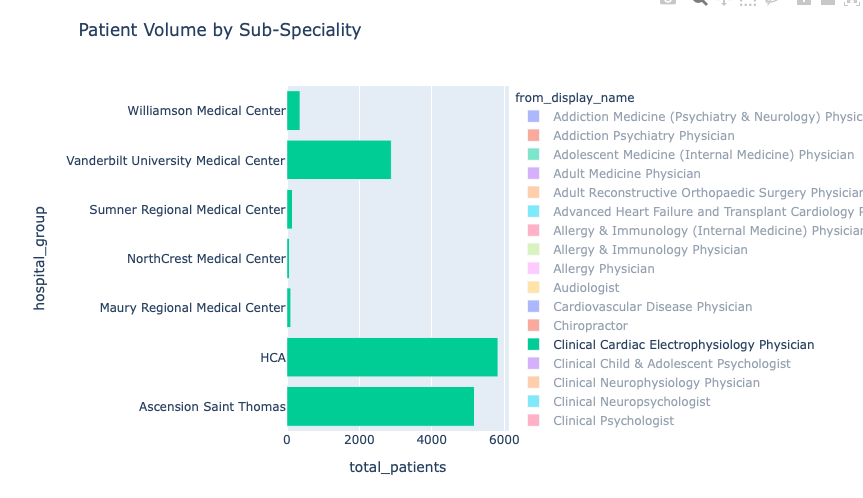

#### Family Medicine
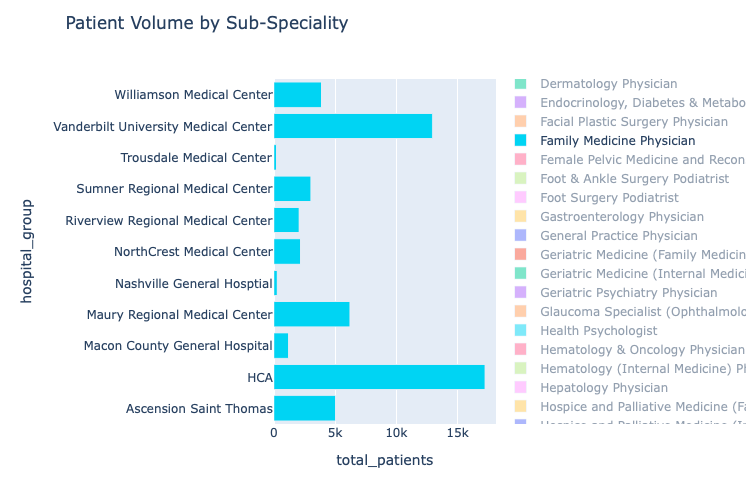

#### Gastroenterology
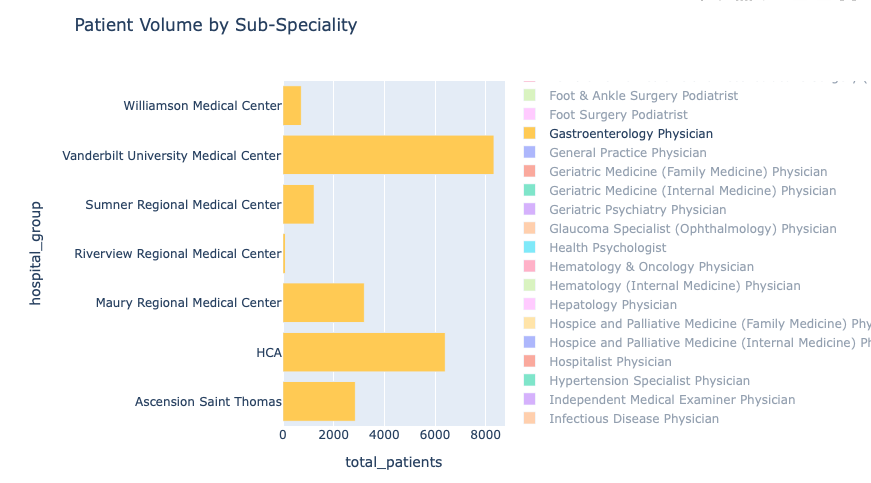

#### Internal Medicine

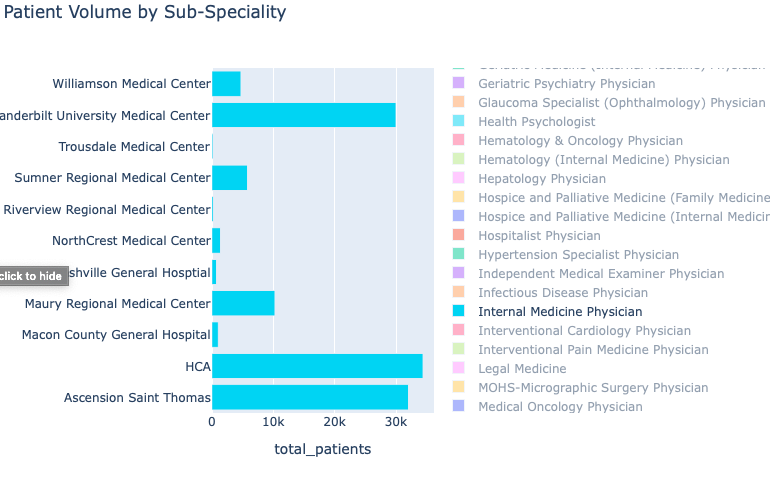


#### Interventional Cardiology

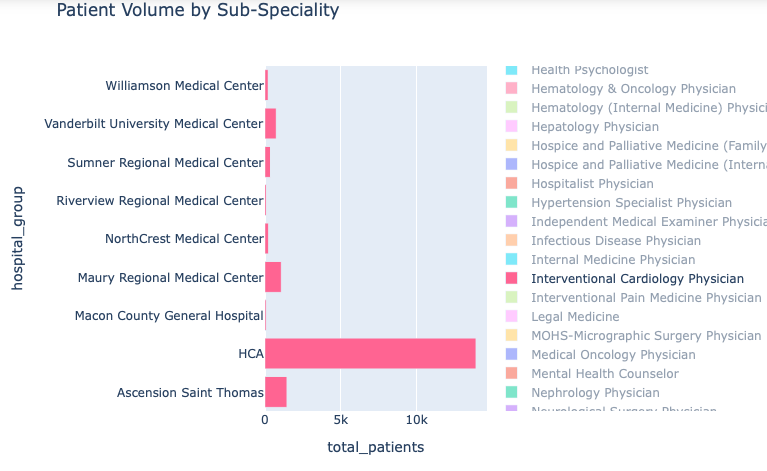

#### Nephrology

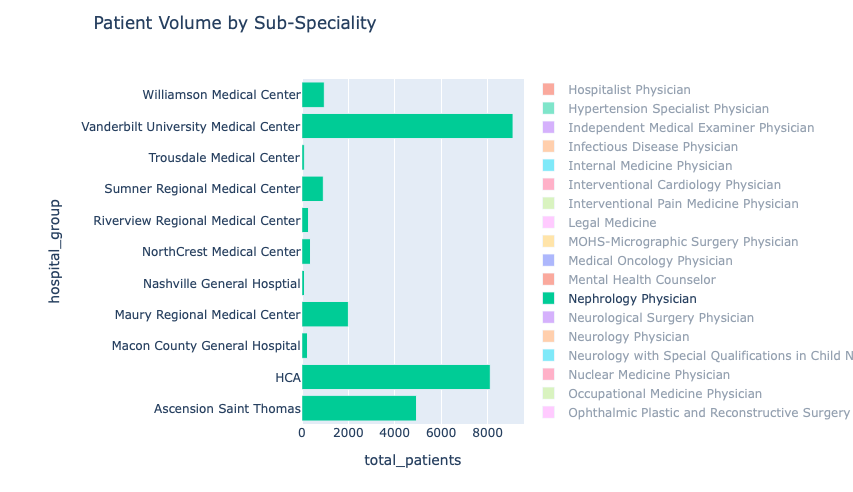

#### Orthopaedic Surgery

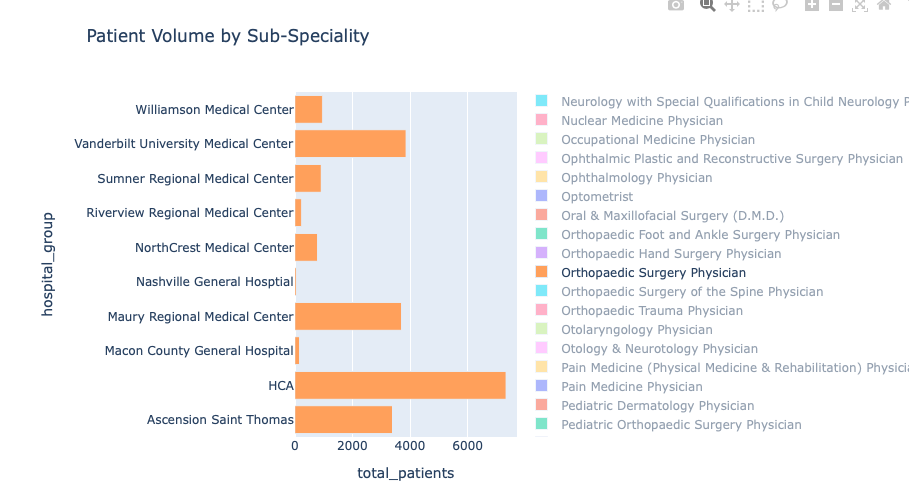

#### Orthopaedic Surgery of the Spine

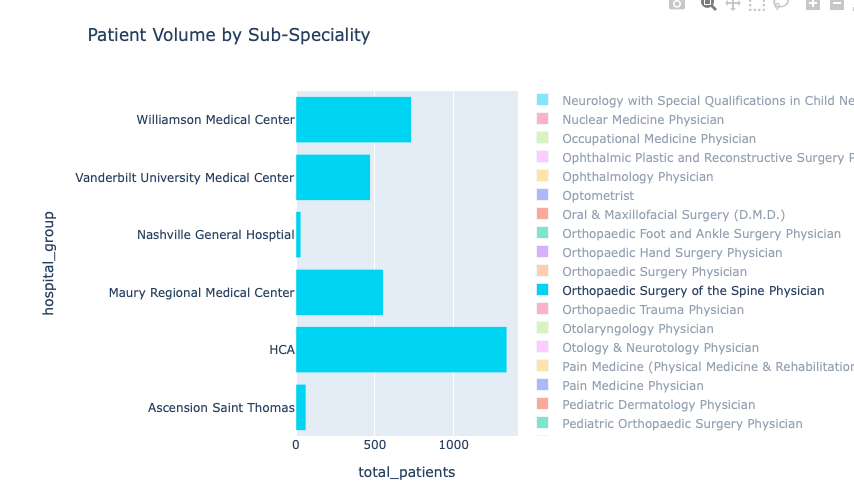

#### Pulmonary Disease

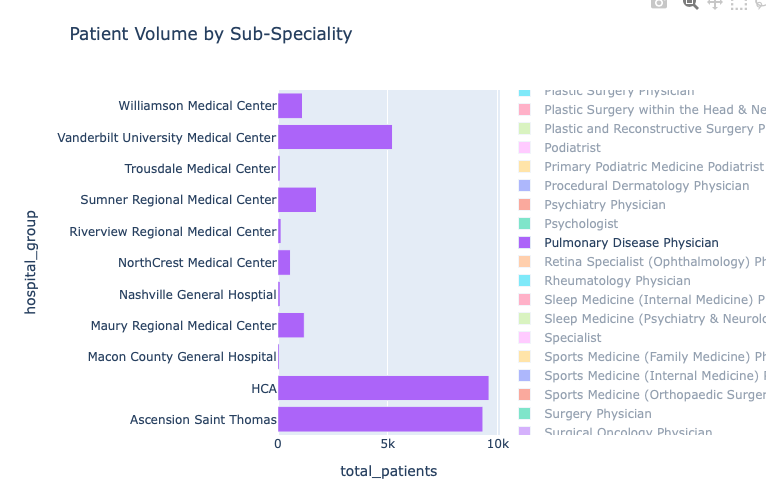

#### Cardiothorasic Surgery

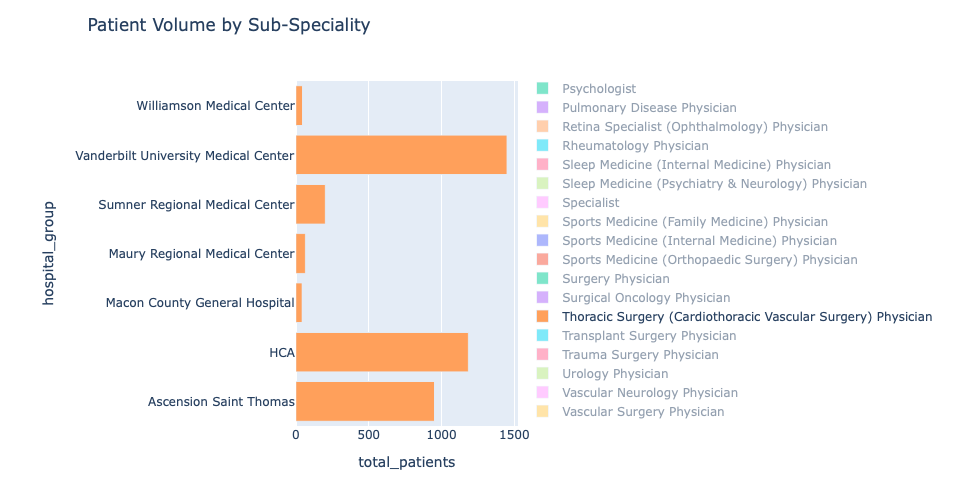

#### Vascular Surgery

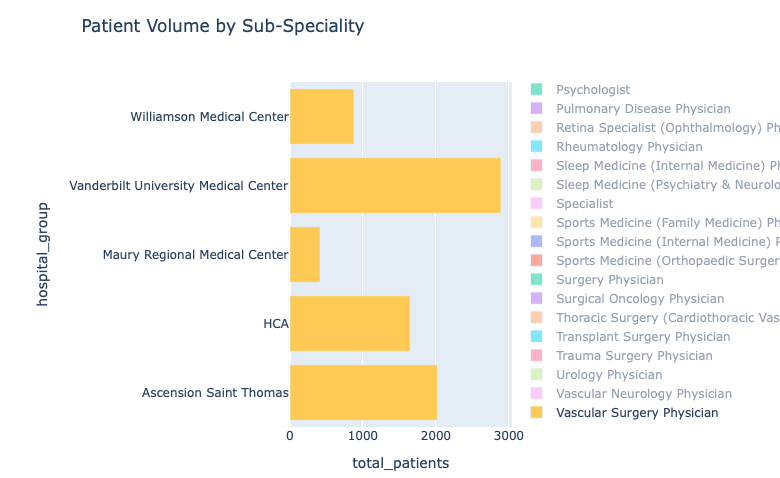

### Urology

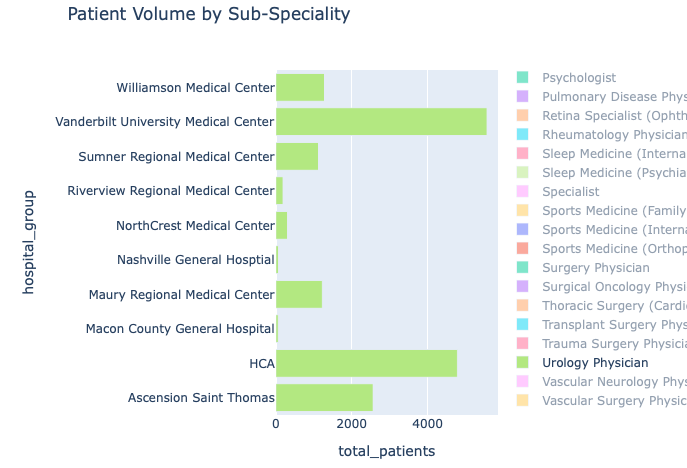

### Orthopedics & Podiatry

In [23]:
db = sqlite3.connect('../data/nppes_lite.sqlite') #reopen the connection

#select facility name where facility has to_grouping of 'Hospitals'

query = """
SELECT
    from_classification,
---    from_display_name,
    hospital_group,
    COUNT(DISTINCT(from_npi)) AS count_from_npi,
    COUNT(DISTINCT(to_facility)) AS count_facilities,
    SUM(patient_count) AS total_patients,
    SUM(transaction_count) AS total_transactions,
    ROUND((SUM(transaction_count)*1.00)/(SUM(patient_count)),2) as trans_per_pt
FROM hosp_refs
WHERE from_grouping NOT IN ('Managed Care Organizations',
                            'Nursing Service Providers',
                            'Suppliers',
                            'Transportation Services',
                            'Managed Care Organizations',
                            'Dental Providers',
                            'Laboratories',
                            'Physician Assistants & Advanced Practice Nursing Providers',
                            'Student, Health Care'
                            )
AND from_classification NOT IN ('Radiology',
                            'Pathology',
                             'Anesthesiology',
                           'Emergency Medicine',
                             'Obstetrics & Gynecology',
                             'Pediatrics',
                             'Clinical Pharmacology',
                             'Anesthesiologist Assistant')
AND from_display_name IN ('Adult Reconstructive Orthopaedic Surgery Physician',
                         'Orthopaedic Foot and Ankle Surgery Physician',
                         'Orthopaedic Hand Surgery Physician',
                         'Orthopaedic Surgery Physician',
                         'Orthopaedic Surgery of the Spine Physician',
                         'Orthopaedic Trauma Physician',
                            'Sports Medicine (Orthopaedic Surgery) Physician',
                            'Foot & Ankle Surgery Podiatrist',
                         'Foot Surgery Podiatrist',
                         'Podiatrist',
                         'Primary Podiatric Medicine Podiatrist')
GROUP BY from_classification 
     ---   , from_display_name
        , hospital_group
"""
#                            

ortho_pod = pd.read_sql(query,db)

db.close()
ortho_pod.shape

(19, 7)

In [24]:
ortho_pod

from_classification                        hospital_group  count_from_npi  \
0   Orthopaedic Surgery  Ascension Saint Thomas                31               
1   Orthopaedic Surgery  HCA                                   61               
2   Orthopaedic Surgery  Macon County General Hospital         2                
3   Orthopaedic Surgery  Maury Regional Medical Center         16               
4   Orthopaedic Surgery  Nashville General Hosptial            2                
5   Orthopaedic Surgery  NorthCrest Medical Center             2                
6   Orthopaedic Surgery  Riverview Regional Medical Center     1                
7   Orthopaedic Surgery  Sumner Regional Medical Center        7                
8   Orthopaedic Surgery  Vanderbilt University Medical Center  58               
9   Orthopaedic Surgery  Williamson Medical Center             14               
10  Podiatrist           Ascension Saint Thomas                12               
11  Podiatrist           HCA                                   19               
12  Podiatrist           Macon County General Hospital         1                
13  Podiatrist           Maury Regional Medical Center         5                
14  Podiatrist           NorthCrest Medical Center             1                
15  Podiatrist           Riverview Regional Medical Center     1                
16  Podiatrist           Sumner Regional Medical Center        2                
17  Podiatrist           Vanderbilt University Medical Center  36               
18  Podiatrist           Williamson Medical Center             7                

    count_facilities  total_patients  total_transactions  trans_per_pt  
0   4                 4228            6150                1.45          
1   8                 9525            15564               1.63          
2   1                 157             341                 2.17          
3   1                 4431            7260                1.64          
4   1                 82              193                 2.35          
5   1                 785             1510                1.92          
6   1                 216             451                 2.09          
7   1                 961             1615                1.68          
8   2                 9658            17475               1.81          
9   1                 3569            5776                1.62          
10  3                 1451            2206                1.52          
11  7                 2475            4177                1.69          
12  1                 34              54                  1.59          
13  1                 419             620                 1.48          
14  1                 346             772                 2.23          
15  1                 102             169                 1.66          
16  1                 304             854                 2.81          
17  2                 4120            7689                1.87          
18  1                 1092            1823                1.67

In [26]:
df=ortho_pod
fig = px.bar(df, 
             x='total_patients', 
             color='from_classification',
             y='hospital_group',
            title='Patient Volume by Sub-Speciality in Orthopedic Surgery & Podiatry')
fig.show()

In [27]:
db = sqlite3.connect('../data/nppes_lite.sqlite') #reopen the connection

#select facility name where facility has to_grouping of 'Hospitals'

query = """
SELECT
    from_classification,
    from_display_name,
    hospital_group,
    COUNT(DISTINCT(from_npi)) AS count_from_npi,
    COUNT(DISTINCT(to_facility)) AS count_facilities,
    SUM(patient_count) AS total_patients,
    SUM(transaction_count) AS total_transactions,
    ROUND((SUM(transaction_count)*1.00)/(SUM(patient_count)),2) as trans_per_pt
FROM hosp_refs
WHERE from_grouping NOT IN ('Managed Care Organizations',
                            'Nursing Service Providers',
                            'Suppliers',
                            'Transportation Services',
                            'Managed Care Organizations',
                            'Dental Providers',
                            'Laboratories',
                            'Physician Assistants & Advanced Practice Nursing Providers',
                            'Student, Health Care'
                            )
AND from_classification NOT IN ('Radiology',
                            'Pathology',
                             'Anesthesiology',
                           'Emergency Medicine',
                             'Obstetrics & Gynecology',
                             'Pediatrics',
                             'Clinical Pharmacology',
                             'Anesthesiologist Assistant')
AND from_display_name IN ('Adult Reconstructive Orthopaedic Surgery Physician',
                         'Orthopaedic Foot and Ankle Surgery Physician',
                         'Orthopaedic Hand Surgery Physician',
                         'Orthopaedic Surgery Physician',
                         'Orthopaedic Surgery of the Spine Physician',
                         'Orthopaedic Trauma Physician',
                            'Sports Medicine (Orthopaedic Surgery) Physician')
GROUP BY from_classification 
       , from_display_name
        , hospital_group
"""
#                            

ortho_pod = pd.read_sql(query,db)

db.close()
ortho_pod.shape

(36, 8)

In [29]:
df=ortho_pod
fig = px.bar(df, 
             x='total_patients', 
             color='from_display_name',
             y='hospital_group',
            title='Patient Volume by Sub-Speciality in Orthopedic Surgery')
fig.show()

### Diabetes - Pulmnoary Disease - Hypertension etc.

AND from_display_name IN ( 'Sleep Medicine (Psychiatry & Neurology) Physician',
                            'Pulmonary Disease Physician',
                            'Rheumatology Physician',
                            'Sleep Medicine (Internal Medicine) Physician',
                            'Hypertension Specialist Physician',
                            'Endocrinology, Diabetes & Metabolism Physician')

In [33]:
db = sqlite3.connect('../data/nppes_lite.sqlite') #reopen the connection

#select facility name where facility has to_grouping of 'Hospitals'

query = """
SELECT
    from_classification,
    from_display_name,
    hospital_group,
    COUNT(DISTINCT(from_npi)) AS count_from_npi,
    COUNT(DISTINCT(to_facility)) AS count_facilities,
    SUM(patient_count) AS total_patients,
    SUM(transaction_count) AS total_transactions,
    ROUND((SUM(transaction_count)*1.00)/(SUM(patient_count)),2) as trans_per_pt
FROM hosp_refs
WHERE from_grouping NOT IN ('Managed Care Organizations',
                            'Nursing Service Providers',
                            'Suppliers',
                            'Transportation Services',
                            'Managed Care Organizations',
                            'Dental Providers',
                            'Laboratories',
                            'Physician Assistants & Advanced Practice Nursing Providers',
                            'Student, Health Care'
                            )
AND from_classification  IN ('Internal Medicine')

GROUP BY from_classification,from_display_name, hospital_group
"""
#                            

internal = pd.read_sql(query,db)

db.close()
internal.shape

(134, 8)

In [34]:
internal

from_classification  \
0    Internal Medicine    
1    Internal Medicine    
2    Internal Medicine    
3    Internal Medicine    
4    Internal Medicine    
5    Internal Medicine    
6    Internal Medicine    
7    Internal Medicine    
8    Internal Medicine    
9    Internal Medicine    
10   Internal Medicine    
11   Internal Medicine    
12   Internal Medicine    
13   Internal Medicine    
14   Internal Medicine    
15   Internal Medicine    
16   Internal Medicine    
17   Internal Medicine    
18   Internal Medicine    
19   Internal Medicine    
20   Internal Medicine    
21   Internal Medicine    
22   Internal Medicine    
23   Internal Medicine    
24   Internal Medicine    
25   Internal Medicine    
26   Internal Medicine    
27   Internal Medicine    
28   Internal Medicine    
29   Internal Medicine    
30   Internal Medicine    
31   Internal Medicine    
32   Internal Medicine    
33   Internal Medicine    
34   Internal Medicine    
35   Internal Medicine    
36   Internal Medicine    
37   Internal Medicine    
38   Internal Medicine    
39   Internal Medicine    
40   Internal Medicine    
41   Internal Medicine    
42   Internal Medicine    
43   Internal Medicine    
44   Internal Medicine    
45   Internal Medicine    
46   Internal Medicine    
47   Internal Medicine    
48   Internal Medicine    
49   Internal Medicine    
50   Internal Medicine    
51   Internal Medicine    
52   Internal Medicine    
53   Internal Medicine    
54   Internal Medicine    
55   Internal Medicine    
56   Internal Medicine    
57   Internal Medicine    
58   Internal Medicine    
59   Internal Medicine    
60   Internal Medicine    
61   Internal Medicine    
62   Internal Medicine    
63   Internal Medicine    
64   Internal Medicine    
65   Internal Medicine    
66   Internal Medicine    
67   Internal Medicine    
68   Internal Medicine    
69   Internal Medicine    
70   Internal Medicine    
71   Internal Medicine    
72   Internal Medicine    
73   Internal Medicine    
74   Internal Medicine    
75   Internal Medicine    
76   Internal Medicine    
77   Internal Medicine    
78   Internal Medicine    
79   Internal Medicine    
80   Internal Medicine    
81   Internal Medicine    
82   Internal Medicine    
83   Internal Medicine    
84   Internal Medicine    
85   Internal Medicine    
86   Internal Medicine    
87   Internal Medicine    
88   Internal Medicine    
89   Internal Medicine    
90   Internal Medicine    
91   Internal Medicine    
92   Internal Medicine    
93   Internal Medicine    
94   Internal Medicine    
95   Internal Medicine    
96   Internal Medicine    
97   Internal Medicine    
98   Internal Medicine    
99   Internal Medicine    
100  Internal Medicine    
101  Internal Medicine    
102  Internal Medicine    
103  Internal Medicine    
104  Internal Medicine    
105  Internal Medicine    
106  Internal Medicine    
107  Internal Medicine    
108  Internal Medicine    
109  Internal Medicine    
110  Internal Medicine    
111  Internal Medicine    
112  Internal Medicine    
113  Internal Medicine    
114  Internal Medicine    
115  Internal Medicine    
116  Internal Medicine    
117  Internal Medicine    
118  Internal Medicine    
119  Internal Medicine    
120  Internal Medicine    
121  Internal Medicine    
122  Internal Medicine    
123  Internal Medicine    
124  Internal Medicine    
125  Internal Medicine    
126  Internal Medicine    
127  Internal Medicine    
128  Internal Medicine    
129  Internal Medicine    
130  Internal Medicine    
131  Internal Medicine    
132  Internal Medicine    
133  Internal Medicine    

                                                 from_display_name  \
0    Adolescent Medicine (Internal Medicine) Physician               
1    Advanced Heart Failure and Transplant Cardiology Physician      
2    Advanced Heart Failure and Transplant Cardiology Physician      
3    Advanced Heart Failure and Transplant Cardiology Physician      
4    All

In [46]:
df=internal
fig = px.bar(df, 
             x='total_patients', 
             color='from_display_name',
             y='hospital_group',
            title='Patient Volume by Sub-Speciality in Orthopedic Surgery')
fig.show()

### Pulmonary Disease Specialists

In [16]:
db = sqlite3.connect('../data/nppes_lite.sqlite') #reopen the connection

#select facility name where facility has to_grouping of 'Hospitals'

query = """
SELECT
    from_classification,
    from_display_name,
    hospital_group,
    COUNT(DISTINCT(from_npi)) AS count_from_npi,
    COUNT(DISTINCT(to_facility)) AS count_facilities,
    SUM(patient_count) AS total_patients,
    SUM(transaction_count) AS total_transactions,
    ROUND((SUM(transaction_count)*1.00)/(SUM(patient_count)),2) as trans_per_pt
FROM hosp_refs
WHERE from_grouping NOT IN ('Managed Care Organizations',
                            'Nursing Service Providers',
                            'Suppliers',
                            'Transportation Services',
                            'Managed Care Organizations',
                            'Dental Providers',
                            'Laboratories',
                            'Physician Assistants & Advanced Practice Nursing Providers',
                            'Student, Health Care'
                            )
AND from_classification NOT IN ('Radiology',
                            'Pathology',
                             'Anesthesiology',
                           'Emergency Medicine',
                             'Obstetrics & Gynecology',
                             'Pediatrics',
                             'Clinical Pharmacology',
                             'Anesthesiologist Assistant')
AND from_display_name IN ( 'Pulmonary Disease Physician')
GROUP BY from_classification,from_display_name, hospital_group
"""
#                            

pulmonary = pd.read_sql(query,db)

db.close()
pulmonary.shape

(11, 8)

In [17]:
pulmonary

from_classification            from_display_name  \
0   Internal Medicine   Pulmonary Disease Physician   
1   Internal Medicine   Pulmonary Disease Physician   
2   Internal Medicine   Pulmonary Disease Physician   
3   Internal Medicine   Pulmonary Disease Physician   
4   Internal Medicine   Pulmonary Disease Physician   
5   Internal Medicine   Pulmonary Disease Physician   
6   Internal Medicine   Pulmonary Disease Physician   
7   Internal Medicine   Pulmonary Disease Physician   
8   Internal Medicine   Pulmonary Disease Physician   
9   Internal Medicine   Pulmonary Disease Physician   
10  Internal Medicine   Pulmonary Disease Physician   

                          hospital_group  count_from_npi  count_facilities  \
0   Ascension Saint Thomas                23              3                  
1   HCA                                   22              8                  
2   Macon County General Hospital         1               1                  
3   Maury Regional Medical Center         2               1                  
4   Nashville General Hosptial            2               1                  
5   NorthCrest Medical Center             2               1                  
6   Riverview Regional Medical Center     2               1                  
7   Sumner Regional Medical Center        3               1                  
8   Trousdale Medical Center              2               1                  
9   Vanderbilt University Medical Center  25              2                  
10  Williamson Medical Center             2               1                  

    total_patients  total_transactions  trans_per_pt  
0   9310            11147               1.20          
1   9587            14306               1.49          
2   67              96                  1.43          
3   1187            1923                1.62          
4   91              209                 2.30          
5   572             1056                1.85          
6   133             197                 1.48          
7   1739            2773                1.59          
8   91              119                 1.31          
9   5206            9197                1.77          
10  1104            1922                1.74

In [39]:
df=pulmonary
fig = px.bar(df, 
             x='total_patients', 
            # color='from_classification',
             y='hospital_group',
            title='Patient Volume by Sub-Speciality: Pulmonary Disease')
fig.show()

#py.iplot(fig, filename='patient_volume_pulmonology', auto_open=True)

#py.plot(data, filename = 'basic-line', auto_open=True)

### Internal Medicine - Family Practice - GP

In [191]:
db = sqlite3.connect('../data/nppes_lite.sqlite') #reopen the connection

#select facility name where facility has to_grouping of 'Hospitals'

query = """
SELECT
    from_classification,
    from_display_name,
    hospital_group,
    COUNT(DISTINCT(from_npi)) AS count_from_npi,
    COUNT(DISTINCT(to_facility)) AS count_facilities,
    SUM(patient_count) AS total_patients,
    SUM(transaction_count) AS total_transactions,
    ROUND((SUM(transaction_count)*1.00)/(SUM(patient_count)),2) as trans_per_pt
FROM hosp_refs
WHERE from_grouping NOT IN ('Managed Care Organizations',
                            'Nursing Service Providers',
                            'Suppliers',
                            'Transportation Services',
                            'Managed Care Organizations',
                            'Dental Providers',
                            'Laboratories',
                            'Physician Assistants & Advanced Practice Nursing Providers',
                            'Student, Health Care'
                            )
AND from_classification NOT IN ('Radiology',
                            'Pathology',
                             'Anesthesiology',
                           'Emergency Medicine',
                             'Obstetrics & Gynecology',
                             'Pediatrics',
                             'Clinical Pharmacology',
                             'Anesthesiologist Assistant')
AND from_classification IN ('Family Medicine')
GROUP BY from_classification,from_display_name, hospital_group
"""
#    'Internal Medicine', 'General Practice'                        

general = pd.read_sql(query,db)

db.close()
general.shape

(28, 8)

In [192]:
general

from_classification  \
0   Family Medicine      
1   Family Medicine      
2   Family Medicine      
3   Family Medicine      
4   Family Medicine      
5   Family Medicine      
6   Family Medicine      
7   Family Medicine      
8   Family Medicine      
9   Family Medicine      
10  Family Medicine      
11  Family Medicine      
12  Family Medicine      
13  Family Medicine      
14  Family Medicine      
15  Family Medicine      
16  Family Medicine      
17  Family Medicine      
18  Family Medicine      
19  Family Medicine      
20  Family Medicine      
21  Family Medicine      
22  Family Medicine      
23  Family Medicine      
24  Family Medicine      
25  Family Medicine      
26  Family Medicine      
27  Family Medicine      

                                              from_display_name  \
0   Adult Medicine Physician                                      
1   Adult Medicine Physician                                      
2   Adult Medicine Physician                                      
3   Adult Medicine Physician                                      
4   Adult Medicine Physician                                      
5   Family Medicine Physician                                     
6   Family Medicine Physician                                     
7   Family Medicine Physician                                     
8   Family Medicine Physician                                     
9   Family Medicine Physician                                     
10  Family Medicine Physician                                     
11  Family Medicine Physician                                     
12  Family Medicine Physician                                     
13  Family Medicine Physician                                     
14  Family Medicine Physician                                     
15  Family Medicine Physician                                     
16  Geriatric Medicine (Family Medicine) Physician                
17  Geriatric Medicine (Family Medicine) Physician                
18  Geriatric Medicine (Family Medicine) Physician                
19  Geriatric Medicine (Family Medicine) Physician                
20  Geriatric Medicine (Family Medicine) Physician                
21  Geriatric Medicine (Family Medicine) Physician                
22  Hospice and Palliative Medicine (Family Medicine) Physician   
23  Hospice and Palliative Medicine (Family Medicine) Physician   
24  Sports Medicine (Family Medicine) Physician                   
25  Sports Medicine (Family Medicine) Physician                   
26  Sports Medicine (Family Medicine) Physician                   
27  Sports Medicine (Family Medicine) Physician                   

                          hospital_group  count_from_npi  count_facilities  \
0   Ascension Saint Thomas                1               1                  
1   HCA                                   1               1                  
2   Maury Regional Medical Center         1               1                  
3   Sumner Regional Medical Center        1               1                  
4   Vanderbilt University Medical Center  1               1                  
5   Ascension Saint Thomas                48              4                  
6   HCA                                   107             8                  
7   Macon County General Hospital         6               1                  
8   Maury Regional Medical Center         20              1                  
9   Nashville General Hosptial            3               1                  
10  NorthCrest Medical Center             14              1                  
11  Riverview Regional Medical Center     8               1                  
12  Sumner Regional Medical Center        26              1                  
13  Trousdale Medical Center              3               1                  
14  Vanderbilt University Medical Center  112             2                  
15  Williamson Medical Center             25            

In [194]:
df=general
fig = px.bar(df, 
             x='total_patients', 
             color='from_display_name',
             y='hospital_group',
            title='Patient Volume by Sub-Speciality in Family Medicine & Hospital Group')
fig.show()

In [189]:
general[general['from_classification']=='Internal Medicine']

from_classification  \
37   Internal Medicine    
38   Internal Medicine    
39   Internal Medicine    
40   Internal Medicine    
41   Internal Medicine    
42   Internal Medicine    
43   Internal Medicine    
44   Internal Medicine    
45   Internal Medicine    
46   Internal Medicine    
47   Internal Medicine    
48   Internal Medicine    
49   Internal Medicine    
50   Internal Medicine    
51   Internal Medicine    
52   Internal Medicine    
53   Internal Medicine    
54   Internal Medicine    
55   Internal Medicine    
56   Internal Medicine    
57   Internal Medicine    
58   Internal Medicine    
59   Internal Medicine    
60   Internal Medicine    
61   Internal Medicine    
62   Internal Medicine    
63   Internal Medicine    
64   Internal Medicine    
65   Internal Medicine    
66   Internal Medicine    
67   Internal Medicine    
68   Internal Medicine    
69   Internal Medicine    
70   Internal Medicine    
71   Internal Medicine    
72   Internal Medicine    
73   Internal Medicine    
74   Internal Medicine    
75   Internal Medicine    
76   Internal Medicine    
77   Internal Medicine    
78   Internal Medicine    
79   Internal Medicine    
80   Internal Medicine    
81   Internal Medicine    
82   Internal Medicine    
83   Internal Medicine    
84   Internal Medicine    
85   Internal Medicine    
86   Internal Medicine    
87   Internal Medicine    
88   Internal Medicine    
89   Internal Medicine    
90   Internal Medicine    
91   Internal Medicine    
92   Internal Medicine    
93   Internal Medicine    
94   Internal Medicine    
95   Internal Medicine    
96   Internal Medicine    
97   Internal Medicine    
98   Internal Medicine    
99   Internal Medicine    
100  Internal Medicine    
101  Internal Medicine    
102  Internal Medicine    
103  Internal Medicine    
104  Internal Medicine    
105  Internal Medicine    
106  Internal Medicine    
107  Internal Medicine    
108  Internal Medicine    
109  Internal Medicine    
110  Internal Medicine    
111  Internal Medicine    
112  Internal Medicine    
113  Internal Medicine    
114  Internal Medicine    
115  Internal Medicine    
116  Internal Medicine    
117  Internal Medicine    
118  Internal Medicine    
119  Internal Medicine    
120  Internal Medicine    
121  Internal Medicine    
122  Internal Medicine    
123  Internal Medicine    
124  Internal Medicine    
125  Internal Medicine    
126  Internal Medicine    
127  Internal Medicine    
128  Internal Medicine    
129  Internal Medicine    
130  Internal Medicine    
131  Internal Medicine    
132  Internal Medicine    
133  Internal Medicine    
134  Internal Medicine    
135  Internal Medicine    
136  Internal Medicine    
137  Internal Medicine    
138  Internal Medicine    
139  Internal Medicine    
140  Internal Medicine    
141  Internal Medicine    
142  Internal Medicine    
143  Internal Medicine    
144  Internal Medicine    
145  Internal Medicine    
146  Internal Medicine    
147  Internal Medicine    
148  Internal Medicine    
149  Internal Medicine    
150  Internal Medicine    
151  Internal Medicine    
152  Internal Medicine    
153  Internal Medicine    
154  Internal Medicine    
155  Internal Medicine    
156  Internal Medicine    
157  Internal Medicine    
158  Internal Medicine    
159  Internal Medicine    
160  Internal Medicine    
161  Internal Medicine    
162  Internal Medicine    
163  Internal Medicine    
164  Internal Medicine    
165  Internal Medicine    
166  Internal Medicine    
167  Internal Medicine    
168  Internal Medicine    
169  Internal Medicine    
170  Internal Medicine    

                                                 from_display_name  \
37   Adolescent Medicine (Internal Medicine) Physician               
38   Advanced Heart Failure and Transplant Cardiology Physician      
39   Advanced Heart Failure and Transplant Cardiology Physician      
40   Advanced Heart Failure and Transplant Cardiology Physician      
41   All

### Filtering for physicians who do don't refer externally

In [ ]:

query = """
WITH CTE AS (SELECT 
	from_npi
FROM filtered_hop 
WHERE  to_facility_group LIKE '%Vanderbilt%' --- 
)
SELECT 
	from_npi,
	Provider_Last_Name,
	Provider_First_Name,
	COUNT(DISTINCT to_facility_group) AS Group_Count,
	SUM(patient_count) AS Total_referrals,
    GROUP_CONCAT(DISTINCT to_facility_group) AS Groups
FROM filtered_hop 
JOIN npidata ON NPI = from_npi
JOIN CBSA ON Zip = Address_Postal_Codes
WHERE from_npi NOT IN (
	SELECT from_npi
	FROM CTE)
GROUP BY from_npi, Provider_Last_Name, Provider_First_Name
HAVING COUNT(DISTINCT to_facility_group) > 1
"""

In [ ]:
db = sqlite3.connect('../data/nppes_lite.sqlite') #reopen the connection

#select facility name where facility has to_grouping of 'Hospitals'

query = """
SELECT
    from_classification,
    hospital_group,
    COUNT(DISTINCT(from_npi)) AS count_from_npi,
    COUNT(DISTINCT(to_facility)) AS count_facilities,
    SUM(patient_count) AS total_patients,
    SUM(transaction_count) AS total_transactions,
    ROUND((SUM(transaction_count)*1.00)/(SUM(patient_count)),2) as trans_per_pt
FROM hosp_refs
WHERE from_grouping NOT IN ('Managed Care Organizations',
                            'Nursing Service Providers',
                            'Suppliers',
                            'Transportation Services',
                            'Managed Care Organizations',
                            'Dental Providers',
                            'Laboratories',
                            'Student, Health Care'
                            )
AND from_classification NOT IN ('Radiology',
                            'Pathology',
                             'Anesthesiology',
                           'Emergency Medicine',
                             'Obstetrics & Gynecology',
                             'Pediatrics',
                             'Clinical Pharmacology',
                             'Anesthesiologist Assistant')
AND from_display_name IN ('Adult Reconstructive Orthopaedic Surgery Physician',
                         'Orthopaedic Foot and Ankle Surgery Physician',
                         'Orthopaedic Hand Surgery Physician',
                         'Orthopaedic Surgery Physician',
                         'Orthopaedic Surgery of the Spine Physician',
                         'Orthopaedic Trauma Physician',
                            'Sports Medicine (Orthopaedic Surgery) Physician',
                            'Foot & Ankle Surgery Podiatrist',
                         'Foot Surgery Podiatrist',
                         'Podiatrist',
                         'Primary Podiatric Medicine Podiatrist')
GROUP BY from_classification, hospital_group
"""
#                            

ortho_pod = pd.read_sql(query,db)

db.close()
ortho_pod.shape

### Radiologist Locations

In [225]:
db = sqlite3.connect('../data/nppes_lite.sqlite') #reopen the connection

#select facility name where facility has to_grouping of 'Hospitals'

query = """
SELECT
    from_display_name,
    COUNT(DISTINCT(from_npi)) AS count_from_npi,
    COUNT(DISTINCT(hospital_group)) AS count_hospital_groups,
    SUM(patient_count) AS total_patients,
    SUM(transaction_count) AS total_transactions,
    ROUND((SUM(transaction_count)*1.00)/(SUM(patient_count)),2) as trans_per_pt
FROM hosp_refs
WHERE from_classification IN ('Radiology')

GROUP BY from_display_name
"""
#                            

radio = pd.read_sql(query,db)

db.close()
radio.shape

(7, 6)

In [226]:
radio

from_display_name  count_from_npi  \
0  Diagnostic Radiology Physician                 190              
1  Neuroradiology Physician                       6                
2  Nuclear Radiology Physician                    1                
3  Pediatric Radiology Physician                  1                
4  Radiation Oncology Physician                   21               
5  Therapeutic Radiology Physician                1                
6  Vascular & Interventional Radiology Physician  8                

   count_hospital_groups  total_patients  total_transactions  trans_per_pt  
0  11                     343407          372253              1.08          
1  2                      5669            6056                1.07          
2  1                      467             475                 1.02          
3  2                      1142            1193                1.04          
4  6                      3869            8795                2.27          
5  1                      207             462                 2.23          
6  4                      7226            7903                1.09

In [223]:
db = sqlite3.connect('../data/nppes_lite.sqlite') #reopen the connection

#select facility name where facility has to_grouping of 'Hospitals'

query = """
SELECT
    COUNT(DISTINCT(from_npi)) AS count_from_npi,
    COUNT(DISTINCT(hospital_group)) AS hospital_groups,
    SUM(patient_count) AS total_patients,
    SUM(transaction_count) AS total_transactions,
    ROUND((SUM(transaction_count)*1.00)/(SUM(patient_count)),2) as trans_per_pt
FROM hosp_refs
WHERE from_classification IN ('Radiology')
AND from_display_name IN ('Diagnostic Radiology Physician')
"""
#                            

radio = pd.read_sql(query,db)

db.close()
radio.shape

(1, 5)

In [224]:
radio

count_from_npi  hospital_groups  total_patients  total_transactions  \
0  190             11               343407          372253               

   trans_per_pt  
0  1.08

In [ ]:
conditions = pd.read_csv('../data/County_Table_Chronic_Conditions_Spending/County_Table_Chronic_Conditions_Spending_2017.xlsx')